# Introduction

In this project, I aimed to address tasks related to data analysis and predictive modeling, having a dataset about soybean cultivars. The primary focus was to understand the data and the factors influencing thousand seed weight (MHG) and to develop accurate predictive models for this.

# Table of Contents

- **Libraries**: First, I imported the necessary libraries. They can be found in `requirements.txt` along with their versions.

- **Data**: I imported the data and took a look at it.

- **Understanding the data**: Next steps were to examine the provided dataset.

- **Cleaning the data:**: This data preprocessing step involved handling missing values, duplicates.

- **Deltas for GY and MHG**: In this part I computed the deltas for the two variables, to see the changes over the 2 seasons.

- **Some further investigation, before training the models**: In this part I handled outliers and did some EDA.

- **Models to predict MHG**: Here, to predict thousand seed weight (MHG), I experimented with various regression models such as Gradient Boosting, Random Forest, Support Vector Regression, and Multi-layer Perceptron. I evaluated these models using cross-validation and selected the best-performing one based on mean squared error. I also did some hypertuning here.

- **Synthetic Data**: In this step, I generated synthetic data for a new cultivar, where I also tested the best performing model to predict MHG.

- **Clusters**: I did clustering techniques to group similar soybean cultivars together based on their characteristics. This involved K-means clustering and visualizing the clusters to gain insights into cultivar groups.

- **Interpretation and Conclusions**: Finally, I interpreted the results obtained from the predictive models and cluster analysis, and added some insights.

# Libraries

In [406]:
# Data manipulation
import pandas as pd
import numpy as np
from joblib import load

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Model selection and evaluation
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

# Dimensionality reduction
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans

# Regression models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Multiprocessing
import multiprocessing

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# Data

## Cultivars information, for reference

In [468]:
file_path = 'data/cultivars-description.ods'

cultivar_description_df = pd.read_excel(file_path)
cultivar_description_df.head()

,Cultivars,Maturation group,Seeds per meter/linear,Density per meter/linear
0,FTR 3190 IPRO,9.0,12.5,250000
1,FTR 4288 IPRO,8.8,11.0,220000
2,NK 8770 IPRO,8.7,16.0,320000
3,M 8606I2X,8.6,10.0,200000
4,M 8644 IPRO,8.6,11.0,220000


## Dataset
### Variables

- **Season:** The season in which the data was collected (integer).
- **Cultivar:** The name of the cultivar (string).
- **Repetition:** The repetition number of the sample (integer).
- **PH:** Plant Height (float).
- **IFP:** Insertion of the First Pod (float).
- **NLP:** Number of Legumes per Plant (float).
- **NGP:** Number of Grains per Plant (float).
- **NGL:** Number of Grains per Pod (float).
- **NS:** Number of Stems (float).
- **MHG:** Thousand Seed Weight (float).
- **GY:** Grain Yield (float).

In [498]:
file_path = 'data/data.csv'
df = pd.read_csv(file_path)

df.head()

,Season,Cultivar,Repetition,PH,IFP,NLP,NGP,NGL,NS,MHG,GY
0,1,NEO 760 CE,1,58.80,15.20,98.2,177.80,1.81,5.2,152.20,3232.82
1,1,NEO 760 CE,2,58.60,13.40,102.0,195.00,1.85,7.2,141.69,3517.36
2,1,NEO 760 CE,3,63.40,17.20,100.4,203.00,2.02,6.8,148.81,3391.46
3,1,NEO 760 CE,4,60.27,15.27,100.2,191.93,1.89,6.4,148.50,3312.58
4,1,MANU IPRO,1,81.20,18.00,98.8,173.00,1.75,7.4,145.59,3230.99


# Understanding the data

In [83]:
rows, col = df.shape
print ("Dimensions of dataset: {}" . format (df.shape))
print ('Rows:', rows, '\nColumns:', col)

Dimensions of dataset: (320, 11)
Rows: 320 
Columns: 11


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Season      320 non-null    int64  
 1   Cultivar    320 non-null    object 
 2   Repetition  320 non-null    int64  
 3   PH          320 non-null    float64
 4   IFP         320 non-null    float64
 5   NLP         320 non-null    float64
 6   NGP         320 non-null    float64
 7   NGL         320 non-null    float64
 8   NS          320 non-null    float64
 9   MHG         320 non-null    float64
 10  GY          320 non-null    float64
dtypes: float64(8), int64(2), object(1)
memory usage: 27.6+ KB


**Cultivar** is an object. **Season** and **Repetition** are integers and the rest of the features are floats. 

In [87]:
df.select_dtypes(include=['object']).describe().T

,count,unique,top,freq
Cultivar,320,40,NEO 760 CE,8


There are 40 unique cultivars, the most frequent being NEO 760 CE.

In [88]:
df.describe() # std means standard deviation

,Season,Repetition,PH,IFP,NLP,NGP,NGL,NS,MHG,GY
count,320.000000,320.000000,320.000000,320.0000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,1.500000,2.500000,68.386781,15.4650,59.088313,135.085844,2.290844,4.071656,168.322313,3418.553794
std,0.500783,1.119785,8.958194,3.0243,20.068187,60.494529,0.840116,1.474531,19.625566,503.003602
min,1.000000,1.000000,47.600000,7.2000,20.200000,47.800000,0.940000,0.400000,127.060000,1538.230000
25%,1.000000,1.750000,62.950000,13.6000,44.350000,95.052500,2.000000,3.000000,153.845000,3126.611552
50%,1.500000,2.500000,67.200000,15.6000,54.500000,123.000000,2.280000,3.800000,166.150000,3397.276724
75%,2.000000,3.250000,74.347500,17.3300,71.220000,161.350000,2.480000,5.000000,183.182500,3708.262931
max,2.000000,4.000000,94.800000,26.4000,123.000000,683.400000,14.860000,9.000000,216.000000,4930.000000


**Season and Repetition** 
   - There are two seasons in the dataset, with each season having four repetitions => an experimental design, possibly with controlled conditions across the seasons

**Variable Ranges**
   - **PH:** The range of plant heights is from 47.6 to 94.8 => variability in plant growth across the dataset
   - **IFP:** The range is from 7.2 to 26.4 => differences in the developmental stages of the plants
   - **NLP and NGP:** Both variables show a wide range of values => variability in reproductive success and yield potential among plants
   - **NGL:** The range is from 0.94 to 14.86, indicating variability in pod fertility and grain development
   - **NS** Ranges from 0.4 to 9, showing variability in plant architecture
   - **MHG and GY:** Both variables have substantial ranges, indicating variability in grain production across the dataset


**Potential Outliers:** Some variables have a significant difference between the 75th percentile and the maximum value (e.g., NGP, NGL, and GY) => presence of potential outliers in the upper range of these variables

# Cleaning the data

## Negative values

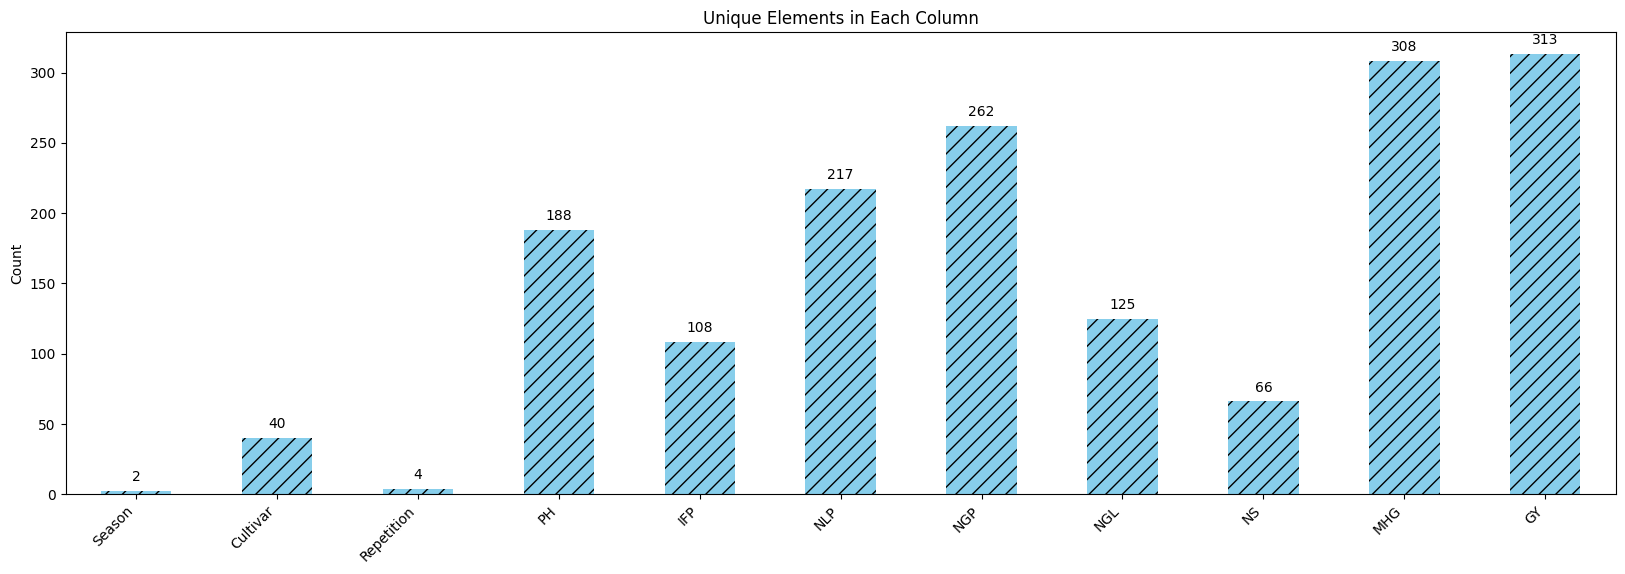

In [229]:
# If there is a negative, the bar will be red

numeric_columns = df.select_dtypes(include=np.number)
negative_values = (numeric_columns < 0).any()

unique = df.nunique()
colors = ['skyblue' if not is_negative else 'red' for is_negative in negative_values]
plt.figure(figsize=(20, 6))
unique.plot(kind='bar', color=colors, hatch='//')
plt.title('Unique Elements in Each Column')
plt.ylabel('Count')
for i, v in enumerate(unique.values):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')
plt.xticks(rotation=45, ha='right')
plt.show()


No negative values!

In [470]:
# Missing values

missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
Season        0
Cultivar      0
Repetition    0
PH            0
IFP           0
NLP           0
NGP           0
NGL           0
NS            0
MHG           0
GY            0
dtype: int64


In [471]:
# Duplicates

duplicates = df.duplicated()
print("Duplicate rows:", duplicates.any())

Duplicate rows: False


As we can see, there are no null values nor duplicates. There is no need for handling any missing data or to remove rows.

# Deltas for GY and MHG

In [499]:
season_avg = df.groupby('Season')[['MHG', 'GY']].mean()

delta_mhg = season_avg.loc[2, 'MHG'] - season_avg.loc[1, 'MHG']
delta_gy = season_avg.loc[2, 'GY'] - season_avg.loc[1, 'GY']

### First, let's see the delta for GY across the seasons.

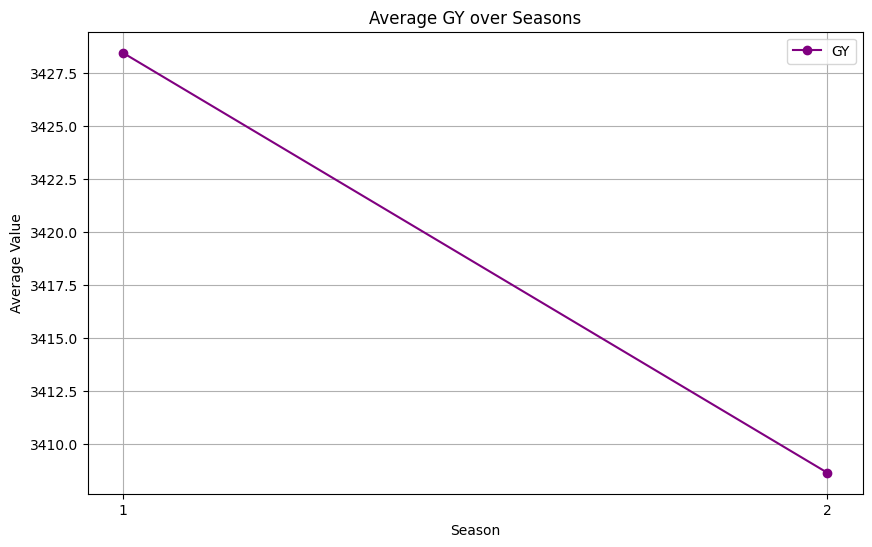

Delta in GY from Season 1 to Season 2: -19.797286649999933
Grain Yield decreased from Season 1 to Season 2.


In [503]:
season_avg = df.groupby('Season')[['GY']].mean()

plt.figure(figsize=(10, 6))
plt.plot(season_avg.index, season_avg['GY'], marker='o', label='GY', color='purple')
plt.xlabel('Season')
plt.ylabel('Average Value')
plt.title('Average GY over Seasons')
plt.xticks(season_avg.index)
plt.legend()
plt.grid(True)
plt.show()


print("Delta in GY from Season 1 to Season 2:", delta_gy)

if delta_gy > 0:
    print("Grain Yield increased from Season 1 to Season 2.")
elif delta_gy < 0:
    print("Grain Yield decreased from Season 1 to Season 2.")
else:
    print("Grain Yield remained unchanged from Season 1 to Season 2.")


#### Let's see deltas for each cultivar.

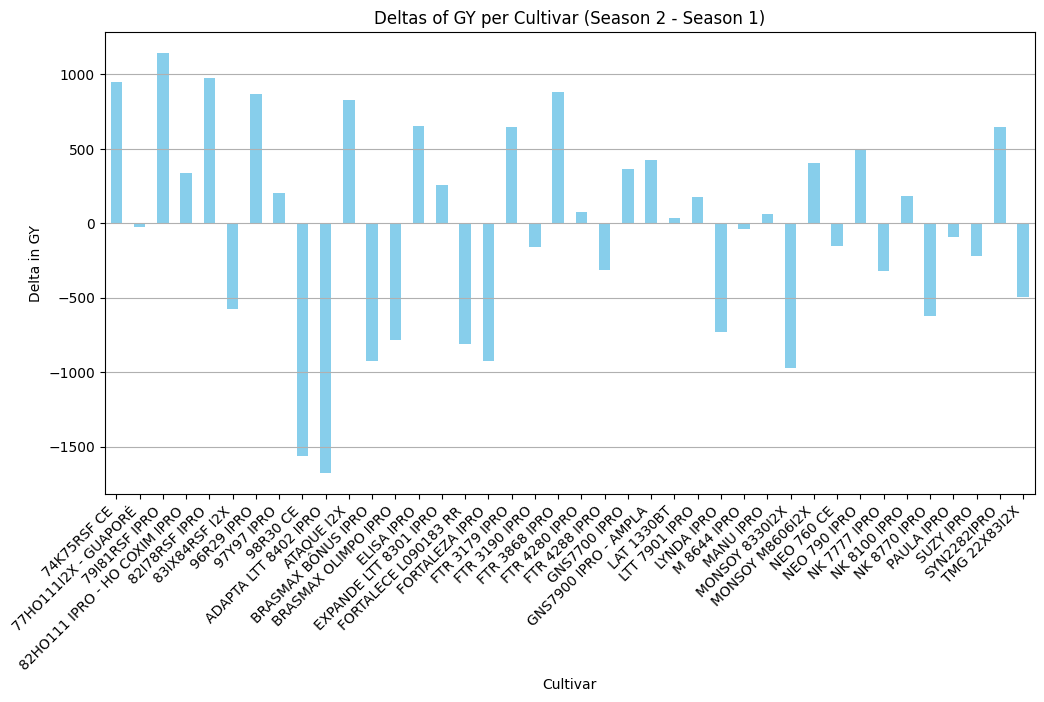

In [505]:
cultivar_avg = df.groupby(['Cultivar', 'Season'])[['GY']].mean().unstack()
cultivar_delta_gy = cultivar_avg['GY'][2] - cultivar_avg['GY'][1]

plt.figure(figsize=(12, 6))
cultivar_delta_gy.plot(kind='bar', color='skyblue')
plt.title('Deltas of GY per Cultivar (Season 2 - Season 1)')
plt.xlabel('Cultivar')
plt.ylabel('Delta in GY')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


### Now, let's see the delta for MHG across the seasons.

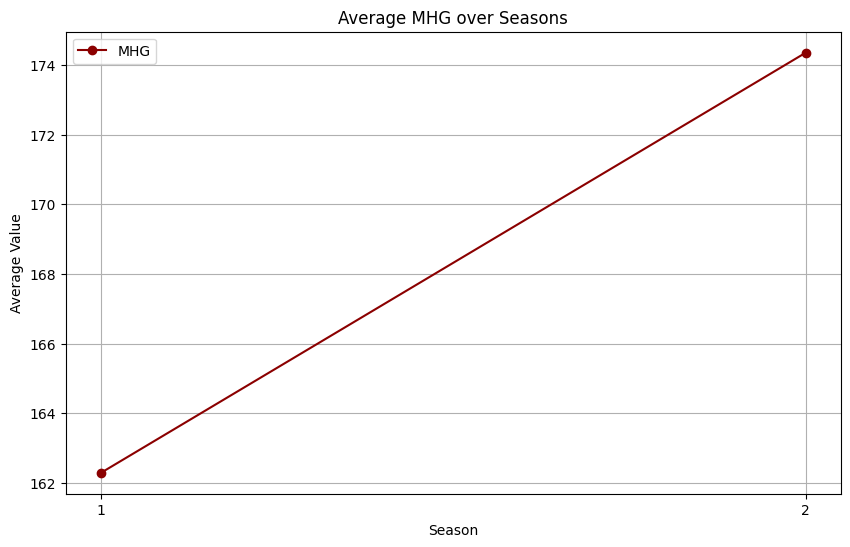

Delta in MHG from Season 1 to Season 2: 12.067000000000007
Thousand Seed Weight increased from Season 1 to Season 2.


In [506]:
season_avg = df.groupby('Season')[['MHG']].mean()

plt.figure(figsize=(10, 6))
plt.plot(season_avg.index, season_avg['MHG'], marker='o', label='MHG', color='darkred')
plt.xlabel('Season')
plt.ylabel('Average Value')
plt.title('Average MHG over Seasons')
plt.xticks(season_avg.index)
plt.legend()
plt.grid(True)
plt.show()

print("Delta in MHG from Season 1 to Season 2:", delta_mhg)

if delta_mhg > 0:
    print("Thousand Seed Weight increased from Season 1 to Season 2.")
elif delta_mhg < 0:
    print("Thousand Seed Weight decreased from Season 1 to Season 2.")
else:
    print("Thousand Seed Weight remained unchanged from Season 1 to Season 2.")

#### And for each cultivar.

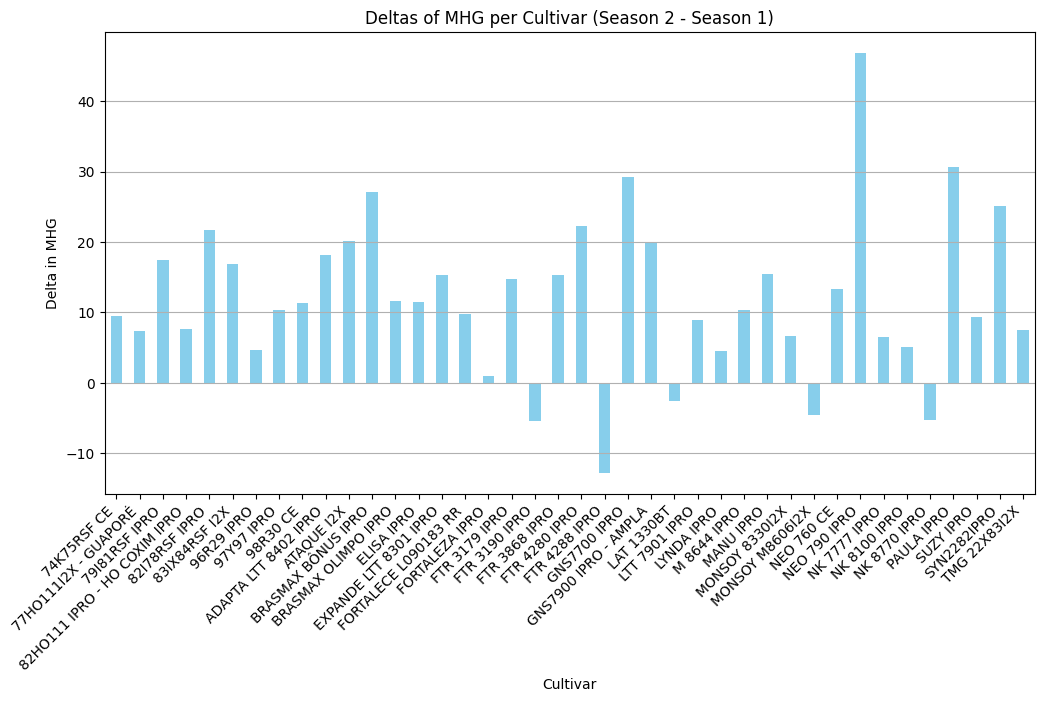

In [508]:
cultivar_avg = df.groupby(['Cultivar', 'Season'])[['MHG']].mean().unstack()
cultivar_delta_mhg = cultivar_avg['MHG'][2] - cultivar_avg['MHG'][1]

plt.figure(figsize=(12, 6))
cultivar_delta_mhg.plot(kind='bar', color='skyblue')
plt.title('Deltas of MHG per Cultivar (Season 2 - Season 1)')
plt.xlabel('Cultivar')
plt.ylabel('Delta in MHG')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

### Changes over the seasons

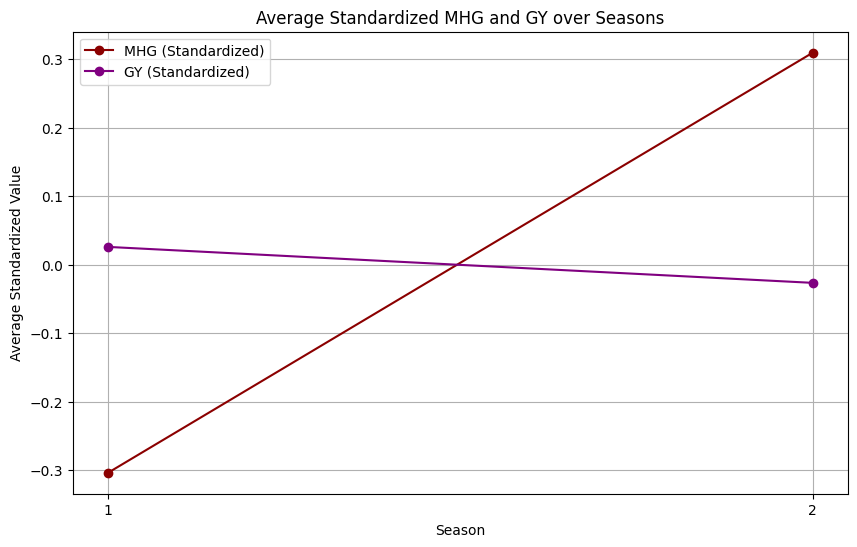

In [585]:
scaler = StandardScaler() # scale them to visualize
df_aux = df
df_aux[['MHG_scaled', 'GY_scaled']] = scaler.fit_transform(df_aux[['MHG', 'GY']])

season_avg_scaled = df_aux.groupby('Season')[['MHG_scaled', 'GY_scaled']].mean()

plt.figure(figsize=(10, 6))
plt.plot(season_avg_scaled.index, season_avg_scaled['MHG_scaled'], marker='o', label='MHG (Standardized)', color='darkred')
plt.plot(season_avg_scaled.index, season_avg_scaled['GY_scaled'], marker='o', label='GY (Standardized)', color='purple')
plt.xlabel('Season')
plt.ylabel('Average Standardized Value')
plt.title('Average Standardized MHG and GY over Seasons')
plt.xticks(season_avg_scaled.index)
plt.legend()
plt.grid(True)
plt.show()

df = df.drop(columns=['MHG_scaled', 'GY_scaled'])

Some notes:
 - The average difference for the 'MHG' variable is 12.06 => for soybeans harvested during Season 2, the thousand seed weight has, on average, increased by 12.06g compared to Season 1
 - The average difference for the 'GY' variable is -19.79 => that for soybeans harvested during Season 2, the grain yield has, on average, decreased by 19.79kg/ha compared to Season 1

# Some further investigation, before training the models

## Box plots and outliers

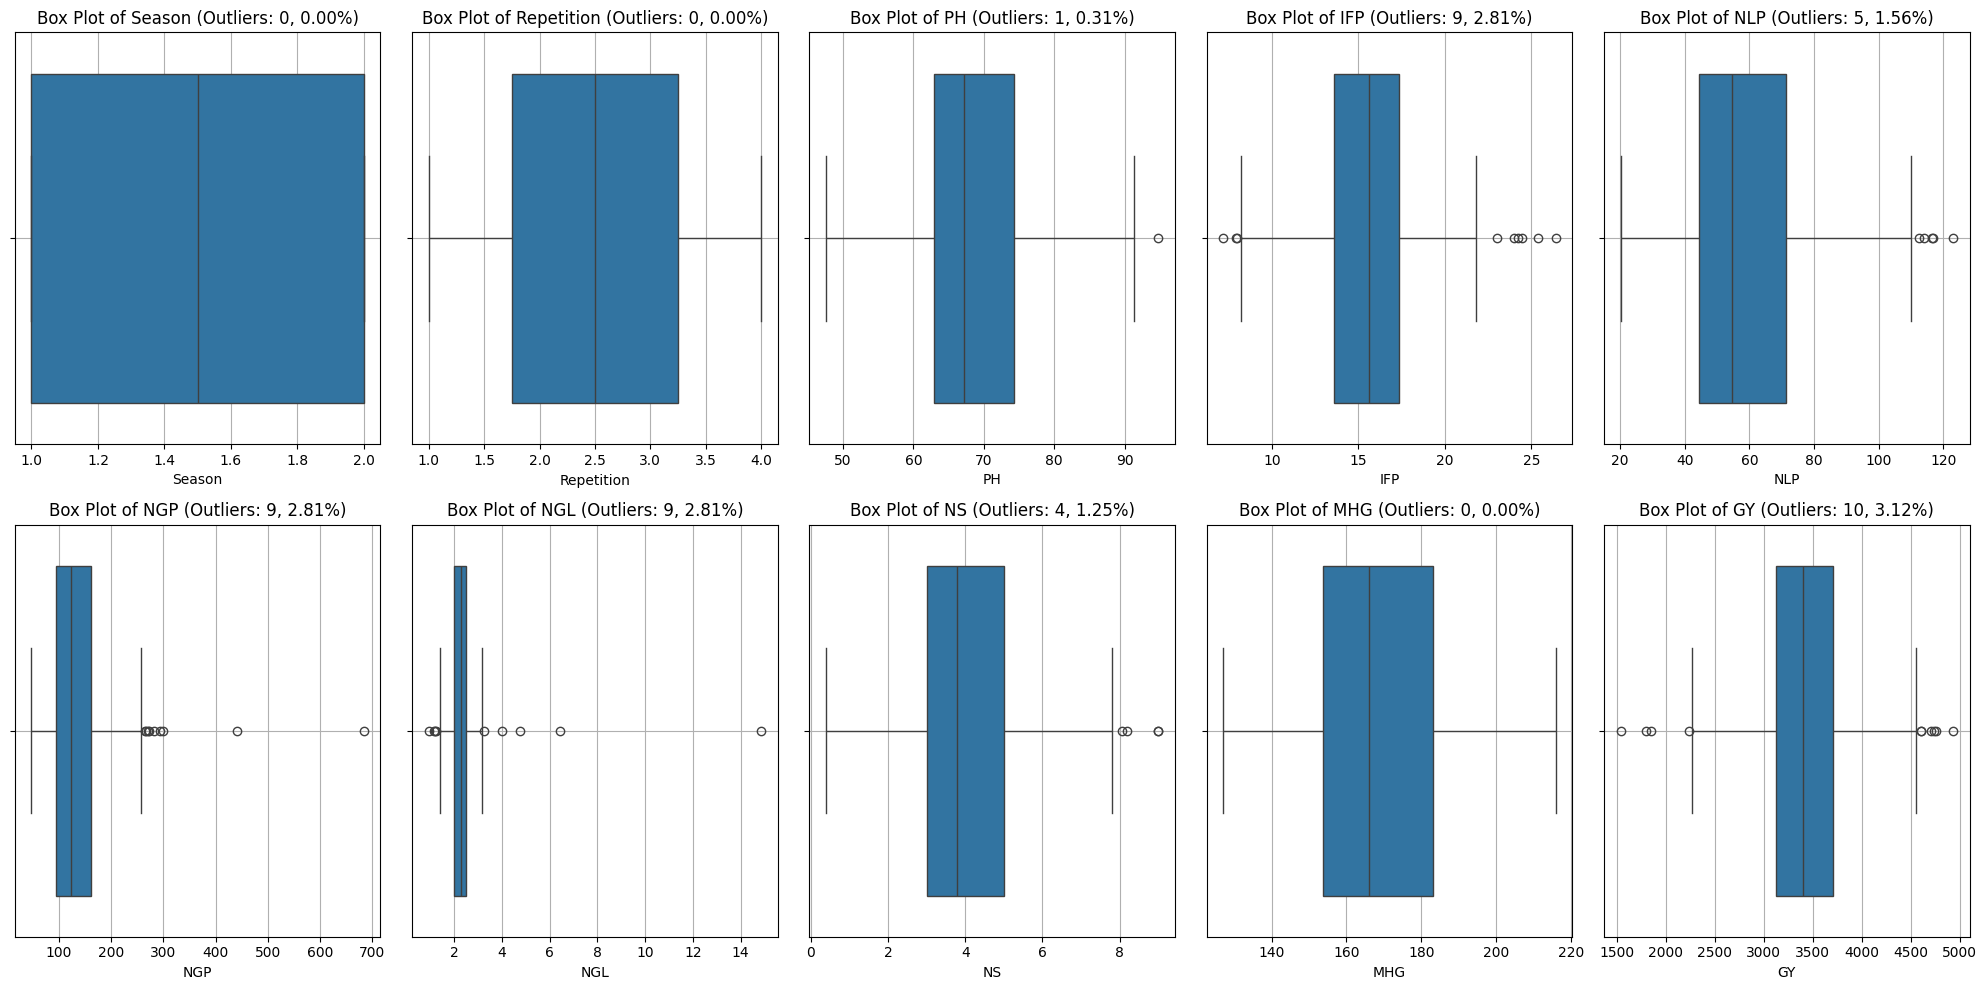

In [509]:
# Box plots
plt.figure(figsize=(20, 10))

for i, feature in enumerate(numerical_features, start=1):
    plt.subplot(2, 5, i)
    
    # Quartiles
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    # Upper and lower bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Outliers
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    
    # Percentage of outliers
    outlier_percentage = len(outliers) / len(df) * 100
    
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature} (Outliers: {len(outliers)}, {outlier_percentage:.2f}%)')
    plt.xlabel(feature)
    plt.grid(True)

plt.tight_layout()
plt.show()

*Outliers* are data points that significantly deviate from the overall pattern of a dataset. They can occur due to measurement errors, data entry mistakes, natural variation in the data etc.
It's important to deal with them, since they can significantly affect the data and the models we create with it. They can be good, since they might represent opportunities for deeper insights into the data distribution. However, most of the time, we need a specialist to understand if they are genuine observations, or errors.

Here are the outliers:

**PH:** One outlier detected, higher than the upper bound.

**IFP:** Nine outliers detected, with values lower than the lower bound or higher than the upper bound.

**NLP:** Five outliers detected, below the lower bound or above the upper bound.

**NGP:** Nine outliers detected, below the lower bound or above the upper bound.

**NGL:** Nine outliers detected, below the lower bound or above the upper bound.

**NS:** Four outliers detected, below the lower bound or above the upper bound.
   
**GY:** Ten outliers detected, below the lower bound or above the upper bound.

I believe there is a need for further investigation in order to decide what to do with them.

## Distribution of values. Skewness

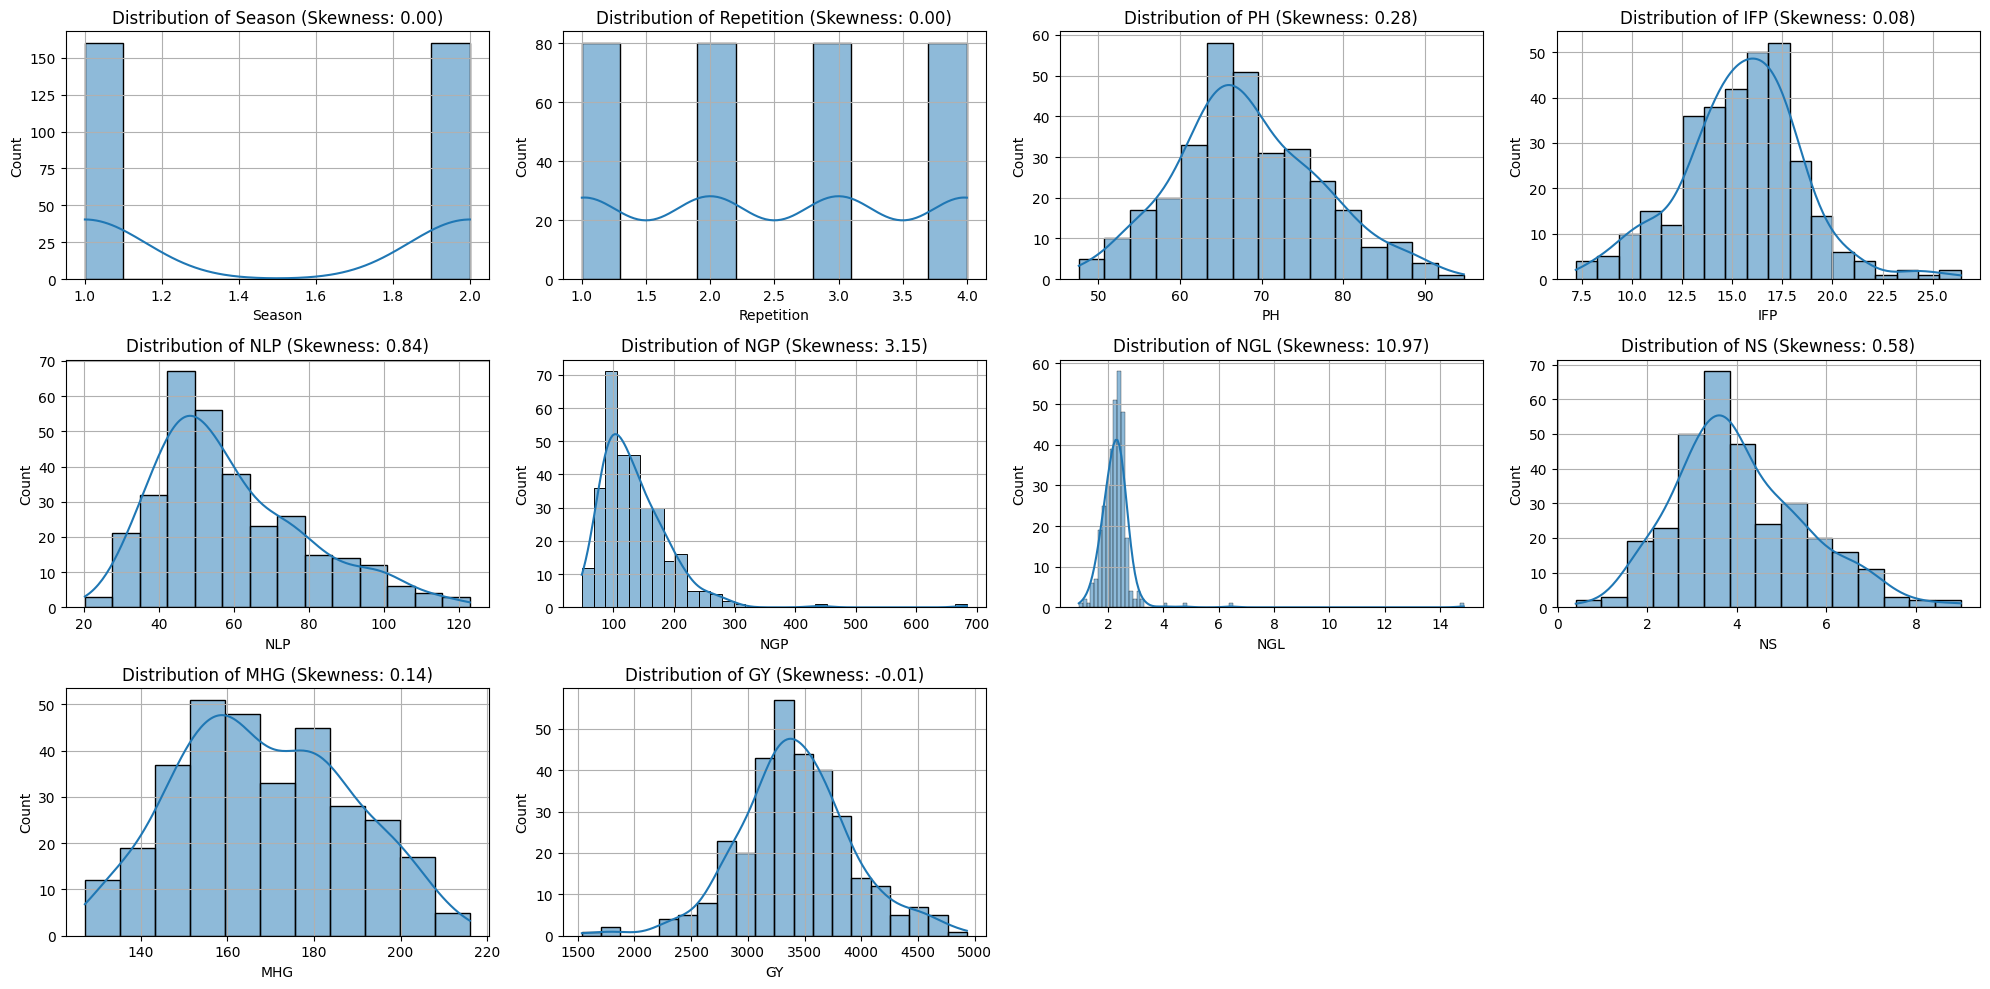

In [510]:
plt.figure(figsize=(20, 10))

for i, column in enumerate(df.drop(columns=['Cultivar'])):
    plt.subplot(3, 4, i+1)
    
    # Skewness
    skewness = df[column].skew()
    
    sns.histplot(df.drop(columns=['Cultivar'])[column], kde=True)
    plt.title(f'Distribution of {column} (Skewness: {skewness:.2f})')
    plt.xlabel(column)
    plt.grid(True)

plt.tight_layout()
plt.show()

#### Skewness 
- a statistical measure that describes the asymmetry of a probability distribution or the shape of a dataset
- indicates the degree to which the data deviates from a normal distribution in terms of its symmetry around the mean

Types:
- a skewness value of 0 indicates a symmetric distribution
- a negative skewness value indicates a left-skewed distribution, with the tail extending towards the lower values
- a positive skewness value indicates a right-skewed distribution, with the tail extending towards the higher values
- the magnitude of skewness indicates the degree of asymmetry: larger values denote more pronounced skewness

Outliers can influence the skewness of a dataset. Extreme values pull the mean in the direction of the tail, affecting the overall symmetry of the distribution and potentially increasing or decreasing the skewness.
There are 2 plots with large skewness value: the one for NGP and the one for NGL. Let's see the differences with and without the outliers.

### Outliers for NGL

Outliers for NGL:
65      4.75
67      3.25
142     0.94
174    14.86
175     6.42
178     1.15
210     1.26
242     1.20
305     4.02
Name: NGL, dtype: float64


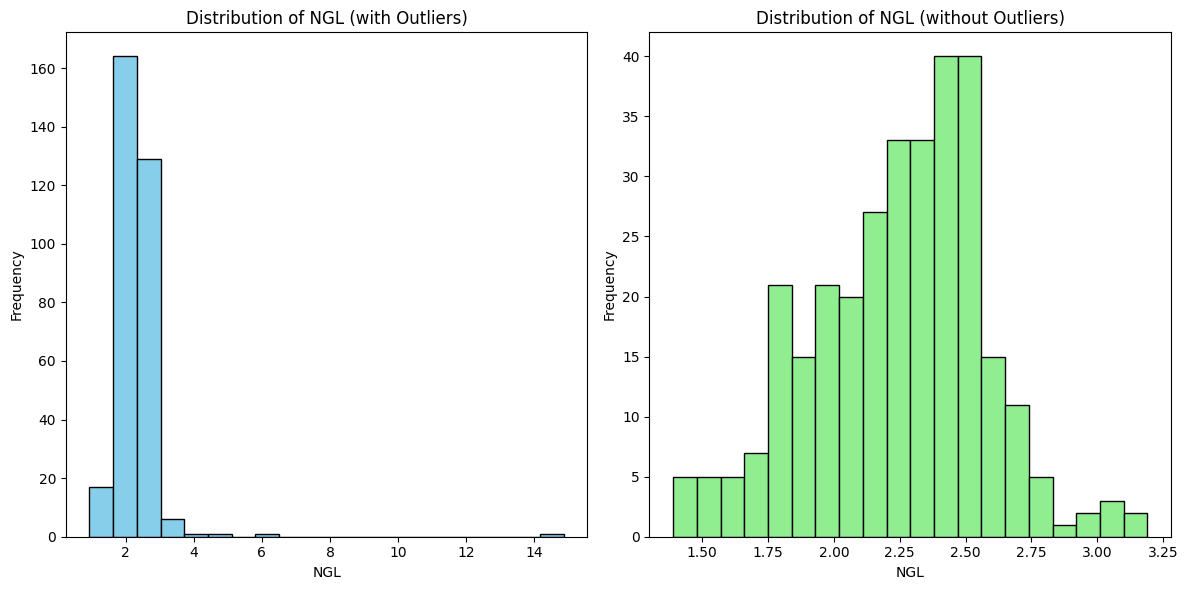

In [511]:
plt.figure(figsize=(12, 6))

# Plot with outliers
plt.subplot(1, 2, 1)
plt.hist(df['NGL'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of NGL (with Outliers)')
plt.xlabel('NGL')
plt.ylabel('Frequency')

# Plot without outliers
plt.subplot(1, 2, 2)

Q1 = df['NGL'].quantile(0.25)
Q3 = df['NGL'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_ngl = df[(df['NGL'] >= lower_bound) & (df['NGL'] <= upper_bound)]['NGL']
plt.hist(filtered_ngl, bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of NGL (without Outliers)')
plt.xlabel('NGL')
plt.ylabel('Frequency')

# Print outliers
outliers_ngl = df[(df['NGL'] < lower_bound) | (df['NGL'] > upper_bound)]['NGL']
print("Outliers for NGL:")
print(outliers_ngl)

plt.tight_layout()
plt.show()

### Outliers for NGP

Outliers for NGP:
14     272.40
174    683.40
175    293.73
204    281.80
206    266.00
216    264.60
305    440.00
307    299.60
317    271.20
Name: NGP, dtype: float64


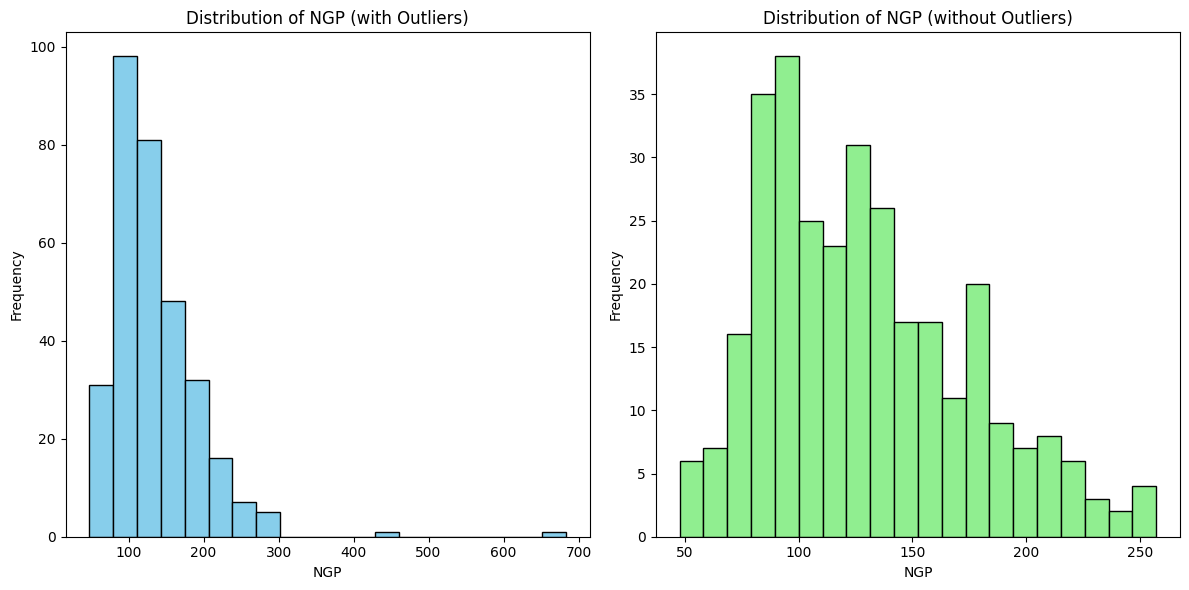

In [512]:
plt.figure(figsize=(12, 6))

# Plot with outliers
plt.subplot(1, 2, 1)
plt.hist(df['NGP'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of NGP (with Outliers)')
plt.xlabel('NGP')
plt.ylabel('Frequency')

# Plot without outliers
plt.subplot(1, 2, 2)

Q1 = df['NGP'].quantile(0.25)
Q3 = df['NGP'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_ngp = df[(df['NGP'] >= lower_bound) & (df['NGP'] <= upper_bound)]['NGP']
plt.hist(filtered_ngp, bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of NGP (without Outliers)')
plt.xlabel('NGP')
plt.ylabel('Frequency')

outliers_ngp = df[(df['NGP'] < lower_bound) | (df['NGP'] > upper_bound)]['NGP']
print("Outliers for NGP:")
print(outliers_ngp)

plt.tight_layout()
plt.show()


I consider that "playing" with the outliers is a delicate task. I don't have enough information to understand what might be an error and what not. However, according to [this article](https://crops.extension.iastate.edu/encyclopedia/soybean-yield-estimates), the average of the number of seeds per pod is **2.5**. So I will "take the risk" and remove data where the NGL is bigger than 5. For the NGP, I have found a lot of articles that talk about variety, so nothing concludent. However, I think that the NGP bigger than 400 is really out of place, especially since there are only 2, so I will still remove this data. The other outliers don't disproportionately affect the skewness of the rest of distributions, so removing them isn't necessary.

In [513]:
# Remove outliers for NGP
df = df[(df['NGP'] <= 400)]

# Remove outliers for NGL
df = df[(df['NGL'] <= 5)]

In [514]:
# Reset index
df.reset_index(drop=True, inplace=True)

In [515]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Season      317 non-null    int64  
 1   Cultivar    317 non-null    object 
 2   Repetition  317 non-null    int64  
 3   PH          317 non-null    float64
 4   IFP         317 non-null    float64
 5   NLP         317 non-null    float64
 6   NGP         317 non-null    float64
 7   NGL         317 non-null    float64
 8   NS          317 non-null    float64
 9   MHG         317 non-null    float64
 10  GY          317 non-null    float64
dtypes: float64(8), int64(2), object(1)
memory usage: 27.4+ KB


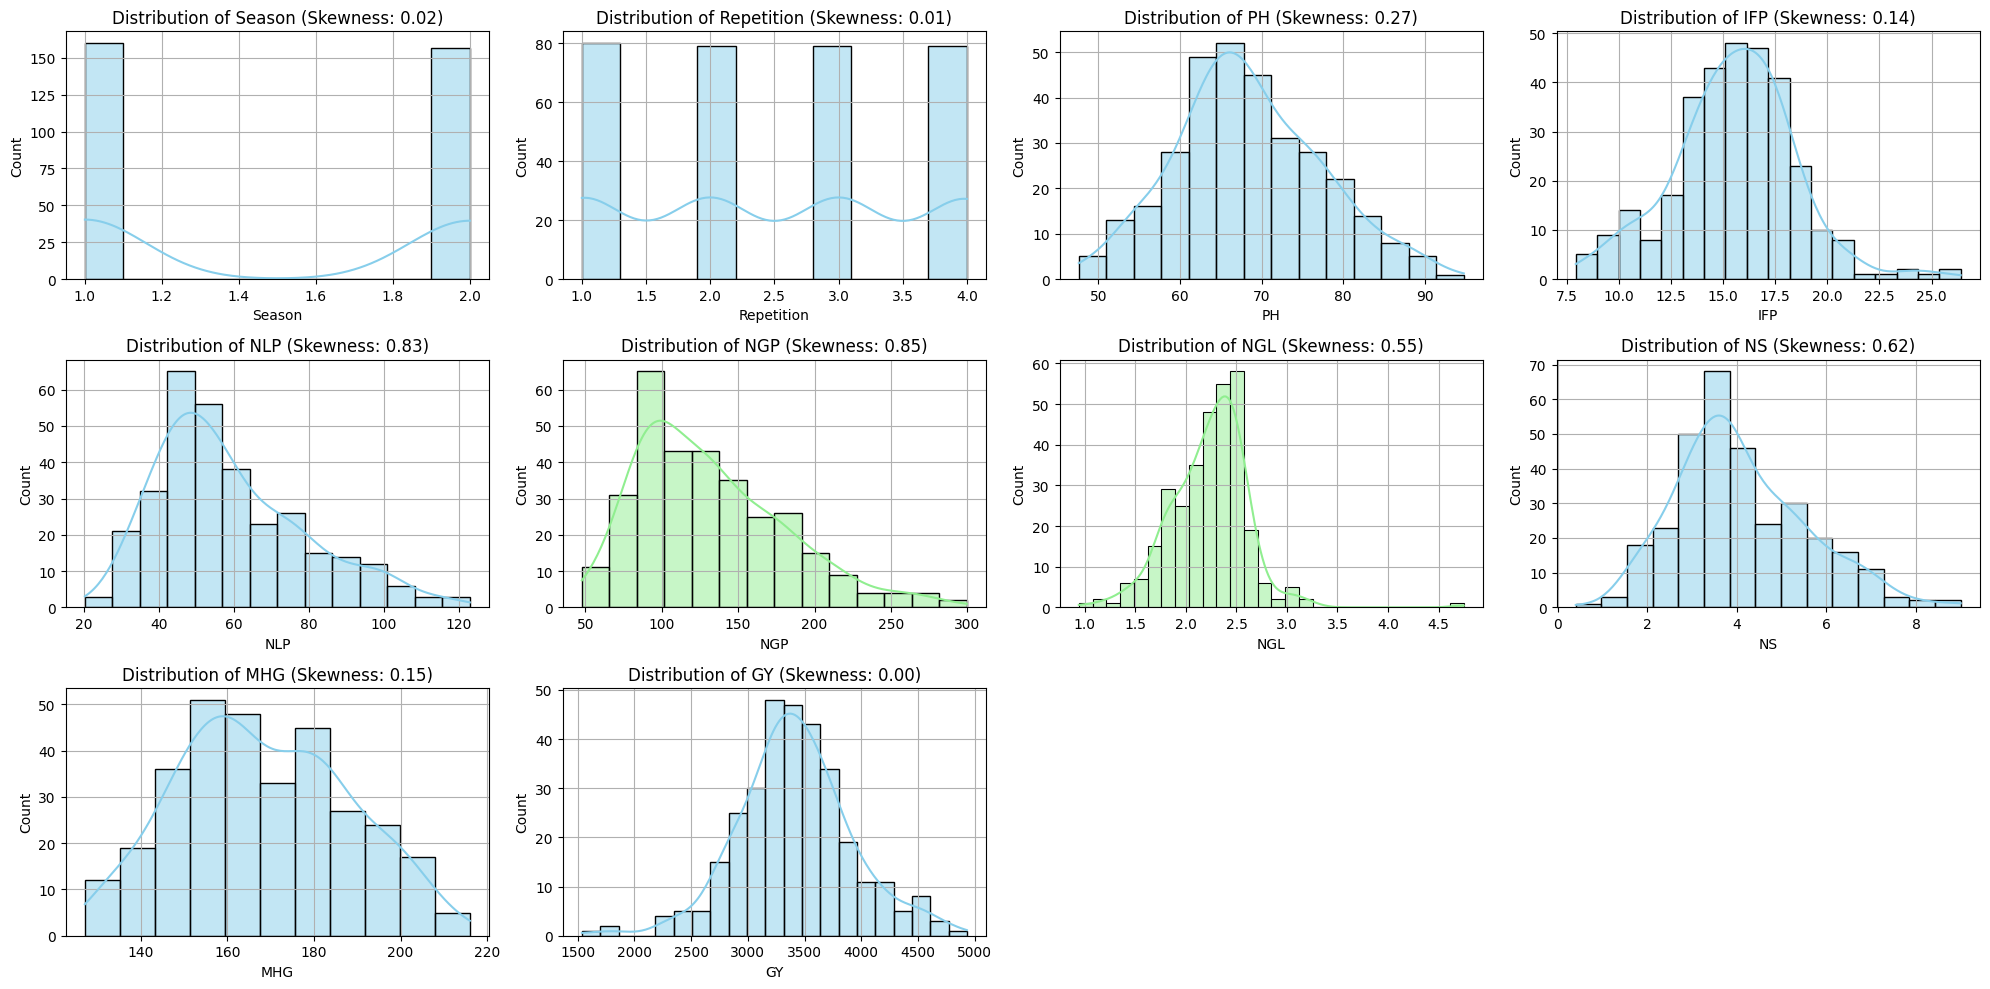

In [496]:
plt.figure(figsize=(20, 10))

for i, column in enumerate(df.drop(columns=['Cultivar'])):
    plt.subplot(3, 4, i+1)
    
    # Skewness
    skewness = df[column].skew()
    
    # Color selection based on column name
    color = 'lightgreen' if column in ['NGP', 'NGL'] else 'skyblue'
    
    sns.histplot(df[column], kde=True, color=color)
    plt.title(f'Distribution of {column} (Skewness: {skewness:.2f})')
    plt.xlabel(column)
    plt.grid(True)

plt.tight_layout()
plt.show()


Now, the skewness is more proportionate for all features.

## Heatmap

### Before I can see the heatmap, I need to deal with categorial columns.

In [587]:
cultivar_encoder = LabelEncoder()
new_df = df
new_df['Cultivar Encoded'] = cultivar_encoder.fit_transform(df['Cultivar'])

new_df = new_df.drop(columns=['Cultivar'])

In [584]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Season            317 non-null    int64  
 1   Repetition        317 non-null    int64  
 2   PH                317 non-null    float64
 3   IFP               317 non-null    float64
 4   NLP               317 non-null    float64
 5   NGP               317 non-null    float64
 6   NGL               317 non-null    float64
 7   NS                317 non-null    float64
 8   MHG               317 non-null    float64
 9   GY                317 non-null    float64
 10  Cultivar Encoded  317 non-null    int32  
 11  MHG_scaled        317 non-null    float64
 12  GY_scaled         317 non-null    float64
dtypes: float64(10), int32(1), int64(2)
memory usage: 31.1 KB


No categorical columns anymore!

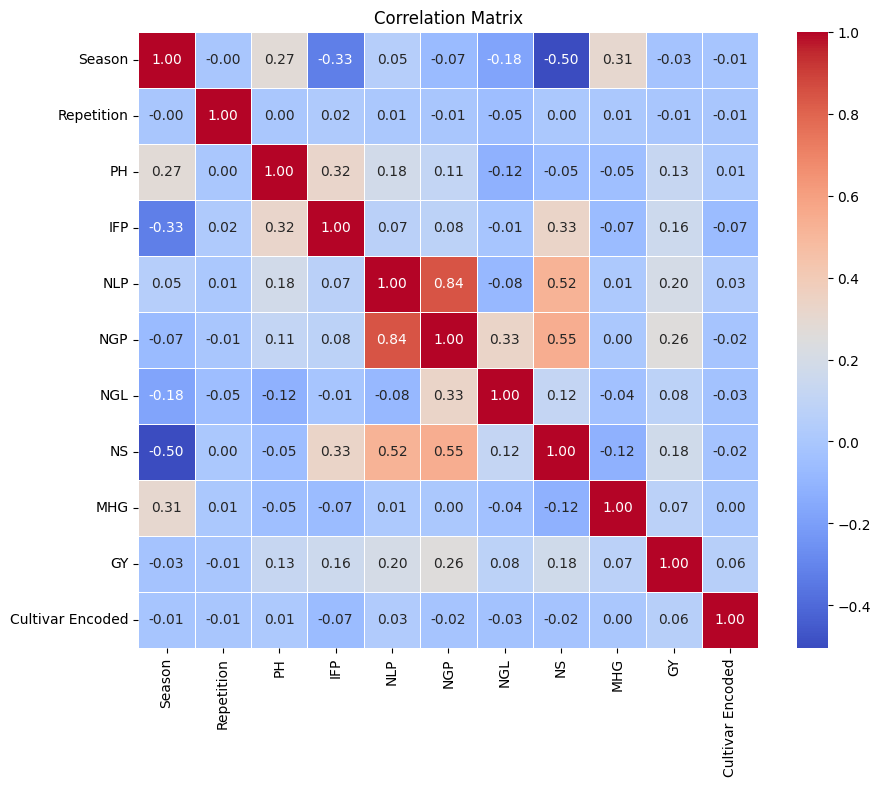

In [517]:
corr_matrix = new_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

- 1: perfect positive correlation (as one variable increases, the other also increases)
- -1: perfect negative correlation (as one variable increases, the other decreases)
- 0: no correlation

In the heatmap:
- **Darker colors** => stronger correlations (closer to -1 or 1)
- **Lighter colors** => weaker correlations (closer to 0)


### Features that contribute the most to GY and MHG, based on correlations

In [522]:
gy_correlation = new_df.corr()['GY'].drop('GY').abs().sort_values(ascending=False)
print("\nMost important factors for GY:")
print(gy_correlation)


Most important factors for GY:
NGP                 0.256171
NLP                 0.196873
NS                  0.175435
IFP                 0.157829
PH                  0.126409
NGL                 0.080819
MHG                 0.073560
Cultivar Encoded    0.055042
Season              0.026249
Repetition          0.007762
Name: GY, dtype: float64


In [523]:
mhg_correlation = new_df.corr()['MHG'].drop('MHG').abs().sort_values(ascending=False)
print("\nMost important factors for MHG:")
print(mhg_correlation)


Most important factors for MHG:
Season              0.306716
NS                  0.117249
GY                  0.073560
IFP                 0.066823
PH                  0.046343
NGL                 0.036259
NLP                 0.011167
Repetition          0.006549
NGP                 0.003287
Cultivar Encoded    0.001711
Name: MHG, dtype: float64


### Let's proceed further with the heatmap.

The biggest correlation that can be noticed in the heatmap is the one between NGP and NLP. Because I don't want any redundancy, I want to remove a column, and since NGP has bigger correlations with other columns, I will remove this one.

In [665]:
new_df_without_NGP = new_df.drop(columns=['NGP'])

In [666]:
new_df_without_NGP

,Season,Repetition,PH,IFP,NLP,NGL,NS,MHG,GY,Cultivar Encoded
0,1,1,58.80,15.20,98.20,1.81,5.20,152.20,3232.820000,31
1,1,2,58.60,13.40,102.00,1.85,7.20,141.69,3517.360000,31
2,1,3,63.40,17.20,100.40,2.02,6.80,148.81,3391.460000,31
3,1,4,60.27,15.27,100.20,1.89,6.40,148.50,3312.580000,31
4,1,1,81.20,18.00,98.80,1.75,7.40,145.59,3230.990000,28
...,...,...,...,...,...,...,...,...,...,...
312,2,4,88.33,16.33,75.73,1.84,3.67,135.19,3348.931034,21
313,2,1,64.40,16.60,76.00,2.21,3.60,145.69,3418.850575,18
314,2,2,64.60,17.60,116.80,2.32,3.80,147.24,3651.586207,18
315,2,3,58.80,14.80,86.40,2.09,2.20,156.32,3487.931034,18


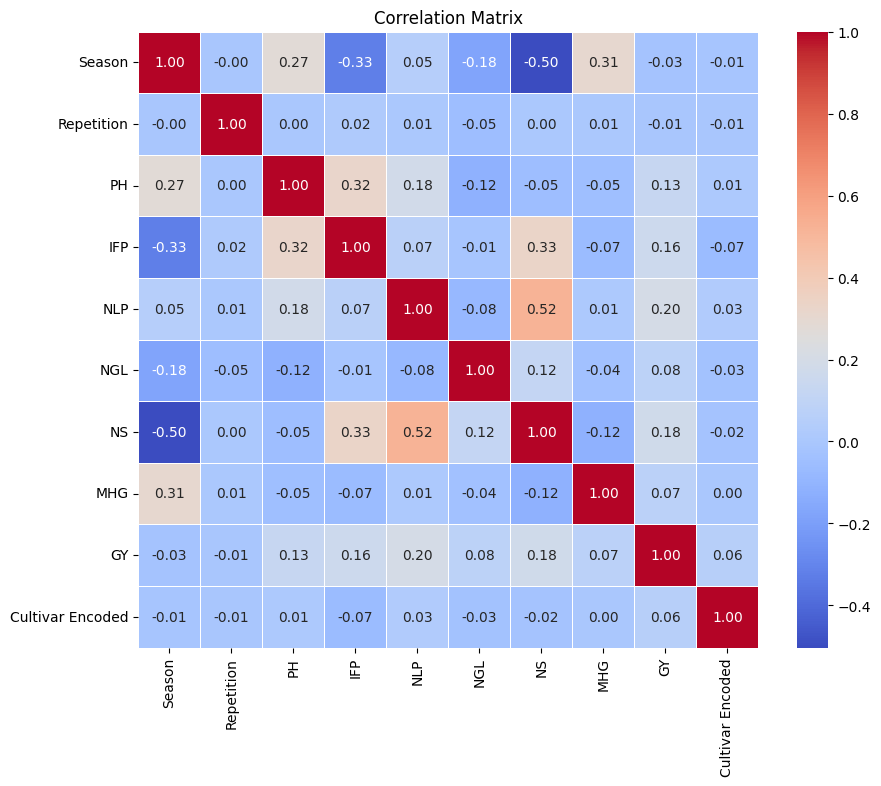

In [667]:
corr_matrix = new_df_without_NGP.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Now it's a little bit better!

# Models to predict MHG

### We start by scaling the data.
MinMax scaling is chosen due to its ability to maintain the original scale and contextual meaning of the features. It also ensures consistency in the range of all features and is less sensitive to outliers.

In [700]:
columns_to_normalize = [col for col in new_df_without_NGP.columns]

scaler = MinMaxScaler()


new_df_normalized = new_df_without_NGP.copy()
new_df_normalized[columns_to_normalize] = scaler.fit_transform(new_df_normalized[columns_to_normalize])


Ultimately, I decided to get rid of **Cultivar Encoded** too. **Cultivar** column is a categorical data anyway, and when I will create the synthetic cultivar, I don't want the label to influence the accuracy.

In [710]:
X = new_df_normalized.drop(columns=['MHG', 'Cultivar Encoded'])
y = new_df_normalized['MHG']
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    'Gradient Boosting': GradientBoostingRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Regression': SVR(),
    'Multi-layer Perceptron': MLPRegressor()
}

parameters = {
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [1.0],
        'min_samples_leaf': [1, 2],
        'min_samples_split': [5, 10]
    },
    'Random Forest': {
        'n_estimators': [50, 150],
        'max_depth': [20],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 2],
        'max_samples': [None, 0.5, 0.7]
    },
    'Support Vector Regression': {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'C': [0.1, 1, 10],
        'epsilon': [0.1, 0.2, 0.5],
        'gamma': ['scale', 'auto']
    },
    'Multi-layer Perceptron': {
        'hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'learning_rate': ['constant', 'adaptive'],
        'alpha': [0.0001, 0.001, 0.01]
    }
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=parameters[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    cv_mse = -cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_cv_mse = cv_mse.mean()
    
    best_model = grid_search.best_estimator_
    y_pred_test = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    results[name] = {'Best Parameters': grid_search.best_params_, 'Mean CV MSE': mean_cv_mse, 'Test MSE': test_mse}
    
    model_folder = 'models'
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)
    with open(os.path.join(model_folder, f'best_model_{name}.pkl'), 'wb') as f:
        pickle.dump(best_model, f)

for name, result in results.items():
    print(f"\n{name} Results:")
    print("Best Parameters:", result['Best Parameters'])
    print("Mean CV MSE:", result['Mean CV MSE'])
    print("Test MSE:", result['Test MSE'])



Training Gradient Boosting...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Training Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Training Support Vector Regression...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Training Multi-layer Perceptron...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Gradient Boosting Results:
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 1.0}
Mean CV MSE: 0.06419908205452528
Test MSE: 0.04137272849081755

Random Forest Results:
Best Parameters: {'max_depth': 20, 'max_samples': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Mean CV MSE: 0.053505649308182725
Test MSE: 0.046477713231552795

Support Vector Regression Results:
Best Parameters: {'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean CV MSE: 0.043814115044379334
Test MSE: 0.0491669871296

- **Gradient Boosting** achieved a mean CV MSE of 0.064 and a Test MSE of 0.041.
- **Random Forest** had a mean CV MSE of 0.054 and a Test MSE of 0.046.
- **Support Vector Regression (SVR)** yielded a mean CV MSE of 0.044 and a Test MSE of 0.049.
- **Multi-layer Perceptron (MLP)** resulted in a mean CV MSE of 0.078 and a Test MSE of 0.064.

Based on these results, the Gradient Boosting model exhibits the lowest Test MSE => GB is the best model.

# Synthetic data

In [705]:
mean_features = new_df.drop(columns=['Cultivar Encoded']).mean()

variation = 0.4

num_synthetic_points = 40
synthetic_data = []
for _ in range(num_synthetic_points):
    synthetic_cultivar = mean_features + np.random.normal(scale=variation, size=len(mean_features))
    synthetic_data.append(np.concatenate([synthetic_cultivar, [max(new_df['Cultivar Encoded']) + 1]]))

synthetic_df = pd.DataFrame(synthetic_data, columns=new_df.columns)

df_with_synthetic = pd.concat([new_df, synthetic_df], ignore_index=True)

df_with_synthetic.to_csv('data/concatenated_synthetic_data.csv', index=False)
synthetic_df.to_csv('data/synthetic_data.csv', index=False)

Here I generateed synthetic data, expanding the dataset's diversity.  A variation parameter is then defined to control the extent of variability in the synthetic data compared to the mean features. The synthetic data points, along with their corresponding 'Cultivar Encoded' labels, are appended to a list. The synthetic data is then converted into a DataFrame and concatenated with the original dataset.

In [711]:
model_path = 'models/best_model_Gradient Boosting.pkl'
best_model = joblib.load(model_path)

In [712]:
columns_to_normalize = [col for col in synthetic_df.columns]

scaler = MinMaxScaler()


new_df_normalized = synthetic_df.copy()
new_df_normalized[columns_to_normalize] = scaler.fit_transform(synthetic_df[columns_to_normalize])

X = new_df_normalized.drop(['MHG', 'NGP', 'Cultivar Encoded'], axis=1)
y = new_df_normalized['MHG']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

y_pred_test = best_model.predict(X)

mse_test = mean_squared_error(y, y_pred_test)

mse_test = mean_squared_error(y, y_pred_test)
print("Mean Squared Error (MSE) on Test Set:", mse_test)

Mean Squared Error (MSE) on Test Set: 0.02182592755986991


The MSE is lower for the synthetic data, but it was expected, since it was created of the data I already had.

### Let's not forget to compute the features that contributed the most to the prediction of MHG!

In [734]:
feature_importance = best_model.feature_importances_
feature_importance_dict = dict(zip(X.columns, feature_importance))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Features contributing most to MHG prediction:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

Features contributing most to MHG prediction:
NLP: 0.3043284014375247
PH: 0.18783837283389665
GY: 0.18189229909012902
NS: 0.126972474194002
NGP: 0.11109930142208636
IFP: 0.05161266947603385
NGL: 0.03625648154632732
MHG: 0.0


# Clusters

In [730]:
df_with_synthetic_copy = df_with_synthetic.copy()

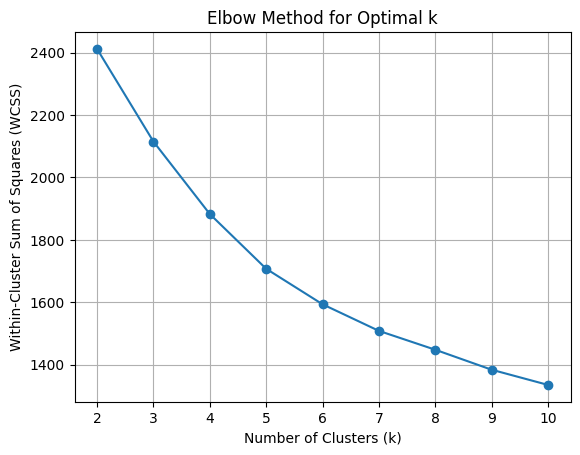

In [724]:
min_clusters = 2
max_clusters = 10

wcss = []

for k in range(min_clusters, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)


plt.plot(range(min_clusters, max_clusters+1), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(min_clusters, max_clusters+1))
plt.grid(True)
plt.show()


The graph is decreasing pretty gradually. I think that from k = 3 the rate decreases a little bit more significantly.

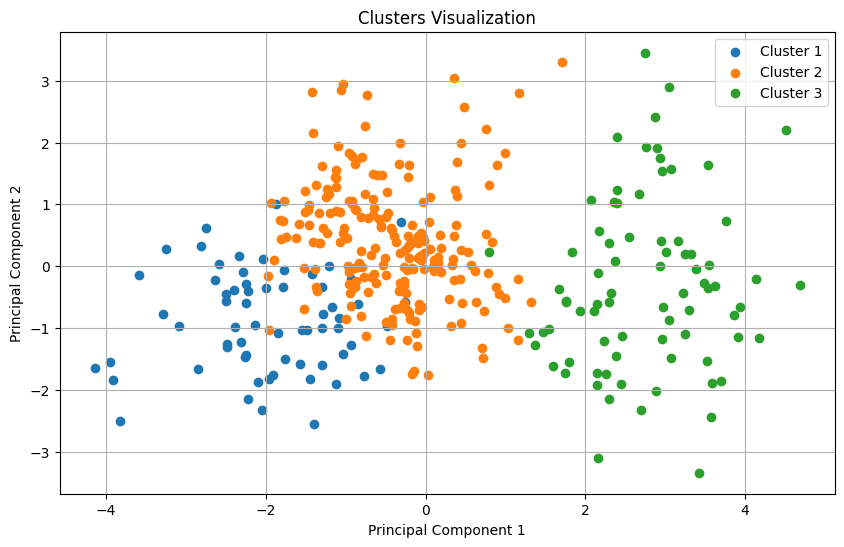

In [731]:
num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_

df_with_synthetic_copy['Cluster'] = cluster_labels

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i+1}')

plt.title('Clusters Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [733]:
# Sizes of each cluster
cluster_sizes = df_with_synthetic_copy['Cluster'].value_counts()
print("Cluster Sizes:")
print(cluster_sizes)

# Centroids of each cluster
cluster_centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_df = pd.DataFrame(cluster_centroids, columns=X.columns)
print("\nCluster Centroids:")
print(centroid_df)

Cluster Sizes:
Cluster
1    214
2     79
0     64
Name: count, dtype: int64

Cluster Centroids:
          PH        IFP        NLP         NGP       NGL        NS  \
0  63.882344  12.375156  49.629375  104.339687  2.155625  2.989531   
1  69.228119  16.129454  52.216476  116.353310  2.236548  3.774783   
2  69.882025  16.454810  84.984051  196.305190  2.297215  5.786582   

          MHG           GY   Cluster  
0  186.610625  3376.742268  3.859375  
1  161.736587  3340.966282  2.098131  
2  170.940633  3648.188840  0.050633  


**Cluster Sizes**:
   - Cluster 1 has the largest number of data points, with 214 observations.
   - Cluster 2 contains 79 observations, indicating a smaller but still significant group.
   - Cluster 0 is the smallest cluster, comprising 64 observations.

**Cluster Centroids** (the average values of the features within the respective cluster):
   - **Cluster 0**:
     - It has relatively lower values for features like PH, IFP, NLP, NGP, NGL, and NS compared to the other clusters.
     - The MHG and GY values are also lower compared to the other clusters.
   - **Cluster 1**:
     - This cluster exhibits moderate values across most features => balanced distribution.
     - The MHG and GY values are relatively higher than Cluster 0 but lower than Cluster 2.
   - **Cluster 2**:
     - It stands out with significantly higher values for features like NLP, NGP, NGL, NS, MHG, and GY compared to the other clusters.
     - This cluster likely represents a distinct group with characteristics that differ from the other clusters.


In [732]:
df_with_synthetic_copy.describe()

,Season,Repetition,PH,IFP,NLP,NGP,NGL,NS,MHG,GY,Cultivar Encoded,Cluster
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,1.507306,2.489990,68.414475,15.528412,59.003770,131.892040,2.235466,4.079198,168.232548,3415.364728,21.691877,1.042017
std,0.489208,1.066308,8.472853,2.797171,18.782029,45.758129,0.386525,1.385895,18.481025,475.081879,12.682389,0.632388
min,0.881640,1.000000,47.600000,7.930000,20.200000,47.800000,0.940000,0.400000,127.060000,1538.230000,0.000000,0.000000
25%,1.000000,2.000000,63.470000,14.070000,45.530000,97.400000,1.989636,3.200000,155.660000,3175.586207,11.000000,1.000000
50%,1.658046,2.426781,68.156243,15.600000,57.400000,130.800000,2.260000,3.904338,167.955485,3415.209309,22.000000,1.000000
75%,2.000000,3.000000,73.600000,17.130000,69.600000,155.200000,2.470000,4.800000,180.340000,3651.586207,33.000000,1.000000
max,2.216117,4.000000,94.800000,26.400000,123.000000,299.600000,4.750000,9.000000,216.000000,4930.000000,40.000000,2.000000


# Conclusions

- The dataset includes observations from two distinct seasons, each with its own set of environmental conditions. The difference in `MHG` and `GY` between the seasons indicates a potential impact of seasonal variation on soybean growth and yield.

- The dataset was good, no duplicates, nor null values.

- Outliers were identified in several variables, which could potentially skew the analysis and model performance. I believe I did a good move by removing extreme values for `NGL` and `NGP`, while other outliers were retained.

- For predicting `MHG` and `GY`, certain features emerged as the most important predictors. For `MHG`, `NLP`, `PH`, and `GY` were the top contributors, while for `GY`, `NGP`, `NLP`, and `NS` played significant roles. I would have wanted to train a RF to understand the most important features that contribute to GY, but I didn't have enough time.

- After clustering, I had three distinct groups based on the characteristics of soybean samples. Cluster 2 stood out with higher values for various features, suggesting a subgroup with potentially superior performance or distinct genetic traits. I think I could have investigated more.

- Gradient Boosting was the best-performing model for predicting `MHG`, exhibiting the lowest test MSE among the evaluated models. Hypertuning was applied to get the best of the model. I think that I could have experimented more with hypertuning, however.

- The generation of synthetic data expanded the dataset's diversity, potentially enhancing model robustness and generalization. However, I believe that testing data should be new, untouched, to determine if a model is good enough.

Overall, the project was a good exercise of data exploration, preprocessing, modeling, and interpretation, even though I wish I had explored more the data.